# Iterate maps modeled in Pytorch Apple M1 (Metal) GPU


In [1]:
import math
from types import SimpleNamespace
from tqdm import tqdm

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import utils.iterated_map_utils as map_utils
import utils.torch_utils as torch_utils

## Model and train

In [2]:
class Model1N1(nn.Module):

    def name(self):
        return self._get_name()

    def __init__(self, num_hidden_units):
        super(Model1N1, self).__init__()

        self.fc1 = nn.Linear(1, num_hidden_units, bias=True)
        # self.fc2 = nn.Linear(num_hidden_units, num_hidden_units)
        self.fc3 = nn.Linear(num_hidden_units, 1, bias=True)

    def forward(self, x):
        x = F.elu(self.fc1(x))
        # x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x


def train(config, device):
    torch_utils.reset_seed(config.seed)

    # create train data
    X_train = np.linspace(0.0, 1.0, config.num_samples)
    np.random.shuffle(X_train)
    Y_train = map_utils.logistic_map(X_train, **config.parameters)
    train_dataset = torch_utils.MpsDataset(X_train, Y_train, device)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    n_steps_per_epoch = math.ceil(len(train_loader.dataset) / config.batch_size)

    # init model
    model = Model1N1(config.num_hidden_units)
    model.to(config.device)

    # Make the loss and optimizer
    loss_fn = torch.nn.MSELoss(reduction='sum')
    if hasattr(config, 'weight_decay'):
        optimizer = torch.optim.Adam(params=model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    else:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=config.learning_rate)
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loss=[]
    train_accuray=[]

    example_ct = 0
    # step_ct = 0
    for epoch in range(config.epochs):
        with tqdm(train_loader, unit=" batch") as tepoch:
            for step, (X, Y) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch}")
                
                X, Y = X.to(device=config.device), Y.to(device=config.device)
                optimizer.zero_grad()
                Y_hat = model(X)
                loss = loss_fn(Y_hat, Y)
                loss.backward()
                optimizer.step()

                correct = (abs(Y_hat - Y)<0.01).sum().item()
                accuracy = correct / config.batch_size

                example_ct += len(Y)

                tepoch.set_postfix(loss=loss.item(), accuracy=100.*accuracy, examples=f'{round(example_ct/1000, 0)}K')

                train_loss.append(loss.item())

                train_accuray.append(accuracy)

    epoch_time = [x/n_steps_per_epoch for x in range(len(train_loss))]
    return model, epoch_time, train_loss, train_accuray
    

## Config

In [3]:
config = SimpleNamespace(
    # reproducability
    seed=33,
    
    # train model
    num_experiments=1,
    model_name="Model1N1",
    num_hidden_units=2,

    # train regime
    batch_size=256,
    epochs=30,

    # train data
    dataset="logistic map",
    map_name="logistic_map",
    parameters = {'r': 3.69},
    num_samples = 40*256,
    
    optimizer="Adam",
    learning_rate=6e-2,
    weight_decay=1e-8,

    # device
    device="mps",
    dtype="float32",
    num_workers=4,
    gpu_name="M1Pro GPU 16 Cores",
    mixed_precision=False,
    channels_last=False,
)

device  = torch_utils.get_device()
model, epoch_time, train_loss, train_accuracy = train(config, device)

pytorch using device: mps


Epoch 29: 100%|██████████| 40/40 [00:00<00:00, 98.48 batch/s, accuracy=84, examples=307.0K, loss=0.0157]  


## Visualize loss

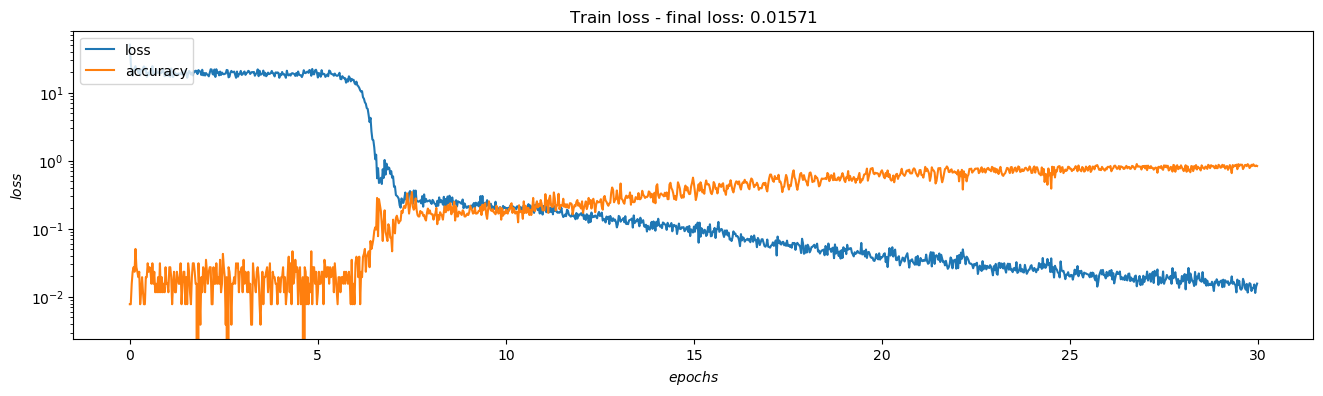

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(epoch_time, train_loss, label='loss')
ax.plot(epoch_time, train_accuracy, label='accuracy')
ax.set_title(f'Train loss - final loss: ${train_loss[-1]: .5f}$')
ax.set_xlabel('$epochs$')
ax.set_ylabel('$loss$')
ax.set_yscale('log')
ax.legend(loc="upper left")

## Visualize actual vs predicted

In [5]:
x0 = 0.1
n=250
X = map_utils.iterate(map_utils.logistic_map, x0, n=n, **config.parameters).astype(float)
Y = map_utils.logistic_map(config.P, X)

X_torch = torch.tensor([[x] for x in X], dtype=torch.float32).to(config.device)
Y_pred = model(X_torch)
Y_pred = [y.item() for y in Y_pred]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)

ax1.plot(Y, marker='.', lw=1,label=f'Actual: $x_0$={x0:.3g}, $n$={n}')
ax1.plot(Y_pred, marker='.', lw=1,label=f'Predict: $x_0$={x0:.3g}, $n$={n}')

ax1.set_xlabel(f'$time$ $→$')
ax1.set_ylabel(f'$x_t$')
ax1.legend(loc="upper left")

# ax1 = plot_trajectories([Y, Y_pred], Ps=['actual', 'predicted'], ax=ax1)
ax1.legend()

# plot mapping
X = np.linspace(0.0, 1.0, 100)
X_linspace = torch.tensor([[x] for x in X], dtype=torch.float32).to(config.device)
Y_model = model(X_linspace)
Y = [y.item() for y in Y_model]

ax2.plot(X, Y, c='b', lw=2)
ax2.plot(X, X, c='b', lw=1)
ax2.set_xlabel('$x_{t}$')
ax2.set_ylabel('$x_{t+1}$')
ax2.set_title(f'model with {config.num_hidden_units} hidden units')

ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

plt.tight_layout()

AttributeError: 'types.SimpleNamespace' object has no attribute 'P'

## In progress - reading model parameters

In [6]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
print(model)
print(f'num_params: {num_params}')

Model1N1(
  (fc1): Linear(in_features=1, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=1, bias=True)
)
num_params: 7


In [7]:
for param in model.parameters():
    if param.requires_grad:
        print(param)

print('\n')

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'{name}: {param.cpu().detach().numpy().flatten()}')

Parameter containing:
tensor([[-2.9364],
        [ 2.3920]], device='mps:0', requires_grad=True)
Parameter containing:
tensor([ 0.5160, -2.1367], device='mps:0', requires_grad=True)
Parameter containing:
tensor([[-1.1309, -1.4305]], device='mps:0', requires_grad=True)
Parameter containing:
tensor([-0.6459], device='mps:0', requires_grad=True)


fc1.weight: [-2.9363608  2.392037 ]
fc1.bias: [ 0.51597077 -2.136721  ]
fc3.weight: [-1.1309311 -1.430543 ]
fc3.bias: [-0.6459283]


/opt/miniconda3/envs/torch-metal/lib/python3.9/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1664817727684/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))
